In [32]:
import sys
import os
root_dir = '/home/qingli/Desktop/Closed-Loop-Learning/nsr/'
os.chdir(root_dir)
from train import *
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_context("notebook", font_scale=1.5)
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [79]:
sys.argv = ['']
args = parse_args()
args.dataset = 'scan'
args.split = 'simple'
args.perception = True
args.resume = 'analysis/models/scan/run-20220921_221927-cwtiabcp/ckpt/model_100.p'
domain = get_dataset(args.dataset)
args.domain = domain
args.train_set = domain('train', n_sample=args.train_size)
args.val_set = domain('val')
args.test_set = domain('test')
model = Jointer(args)
if args.resume:
    st_epoch = model.load(args.resume)

CUDA is available?: True
using cuda?: True


In [42]:
model.syntax.model.embeddings.weight.detach().numpy().shape

(14, 50)

In [ ]:
model.eval()
batch_size = 32
dataloader = torch.utils.data.DataLoader(args.test_set, batch_size=batch_size,
                         shuffle=False, num_workers=4, collate_fn=args.domain.collate)
perm_acc = np.ones((len(domain.vocab), len(domain.vocab)), dtype=float)
for i in trange(len(domain.vocab)):
    for j in range(len(domain.vocab)):
        if i == j: continue
        dep_pred_all = []
        dep_pred_all_perm = []
        for sample in dataloader:
            sent = sample['sentence']
            sent = [x for x in sent if i in x]
            sent_perm = [list(map(lambda y: j if y == i else y, x)) for x in sent]

            parses = model.syntax(sent)
            dep_pred_all.extend([pt.head for pt in parses])

            parses = model.syntax(sent_perm)
            dep_pred_all_perm.extend([pt.head for pt in parses])
            # print(sent, dep_pred_all)
            # print(sent_perm, dep_pred_all_perm)
            # input()
        acc = np.mean([x == y for x, y in zip(dep_pred_all, dep_pred_all_perm)])
        perm_acc[i,j] = acc

100%|██████████| 13/13 [04:24<00:00, 20.34s/it]


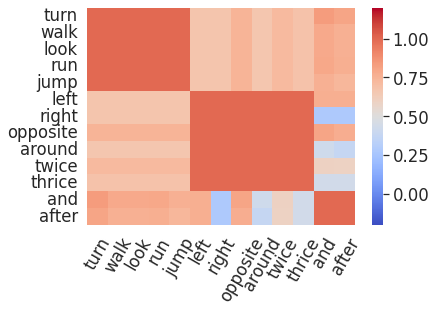

In [124]:
columns = domain.vocab
sns.heatmap((perm_acc + perm_acc.T)/2, 
        xticklabels=columns,
        yticklabels=columns,
        cmap='coolwarm', vmin=-0.2, vmax=1.2)
plt.xticks(
    rotation=60, 
    horizontalalignment='center'
)
plt.savefig('analysis/scan_syntax.pdf', dpi=300, bbox_inches='tight')

100%|██████████| 13/13 [01:09<00:00,  5.31s/it]


<AxesSubplot:>

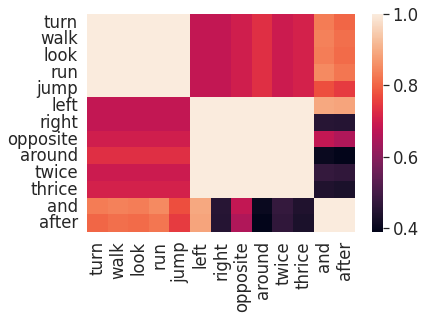

In [95]:
model.eval()
batch_size = 32
dataloader = torch.utils.data.DataLoader(args.train_set, batch_size=batch_size,
                         shuffle=False, num_workers=4, collate_fn=args.domain.collate)
perm_acc_train = np.ones((len(domain.vocab), len(domain.vocab)), dtype=float)
for i in range(len(domain.vocab)):
    for j in trange(len(domain.vocab)):
        if i == j: continue
        dep_pred_all = []
        dep_pred_all_perm = []
        for sample in dataloader:
            sent = sample['sentence']
            sent = [x for x in sent if i in x]
            sent_perm = [list(map(lambda y: j if y == i else y, x)) for x in sent]

            parses = model.syntax(sent)
            dep_pred_all.extend([pt.head for pt in parses])

            parses = model.syntax(sent_perm)
            dep_pred_all_perm.extend([pt.head for pt in parses])
            # print(sent, dep_pred_all)
            # print(sent_perm, dep_pred_all_perm)
            # input()
        acc = np.mean([x == y for x, y in zip(dep_pred_all, dep_pred_all_perm)])
        perm_acc_train[i,j] = acc
columns = domain.vocab
sns.heatmap((perm_acc_train + perm_acc_train.T)/2, 
        xticklabels=columns,
        yticklabels=columns)

In [96]:
np.set_printoptions(precision=2, suppress=True, linewidth=100)
print(perm_acc_train)

[[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.69 0.63]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.74 0.69]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.75 0.7 ]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.75 0.69]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.74 0.69]
 [0.36 0.36 0.36 0.36 0.36 1.   1.   1.   1.   1.   1.   0.87 0.86]
 [0.36 0.36 0.36 0.36 0.36 1.   1.   1.   1.   1.   1.   0.87 0.86]
 [0.4  0.4  0.4  0.4  0.4  1.   1.   1.   1.   1.   1.   0.75 0.7 ]
 [0.47 0.47 0.47 0.47 0.47 1.   1.   1.   1.   1.   1.   0.72 0.69]
 [0.39 0.39 0.39 0.39 0.39 1.   1.   1.   1.   1.   1.   0.48 0.46]
 [0.42 0.42 0.42 0.42 0.42 1.   1.   1.   1.   1.   1.   0.52 0.5 ]
 [0.97 0.94 0.92 0.96 0.81 0.92 0.04 0.61 0.09 0.47 0.36 1.   1.  ]
 [0.97 0.94 0.92 0.96 0.81 0.92 0.04 0.61 0.09 0.47 0.36 1.   1.  ]]


In [61]:
from sklearn import manifold

S_points = model.syntax.model.embeddings.weight.detach().numpy()
S_color = list(range(S_points.shape[0]))

t_sne = manifold.TSNE(
    n_components=2,
    learning_rate=
    perplexity=30,
    n_iter=250,
    init="pca"
)
S_t_sne = t_sne.fit_transform(S_points)

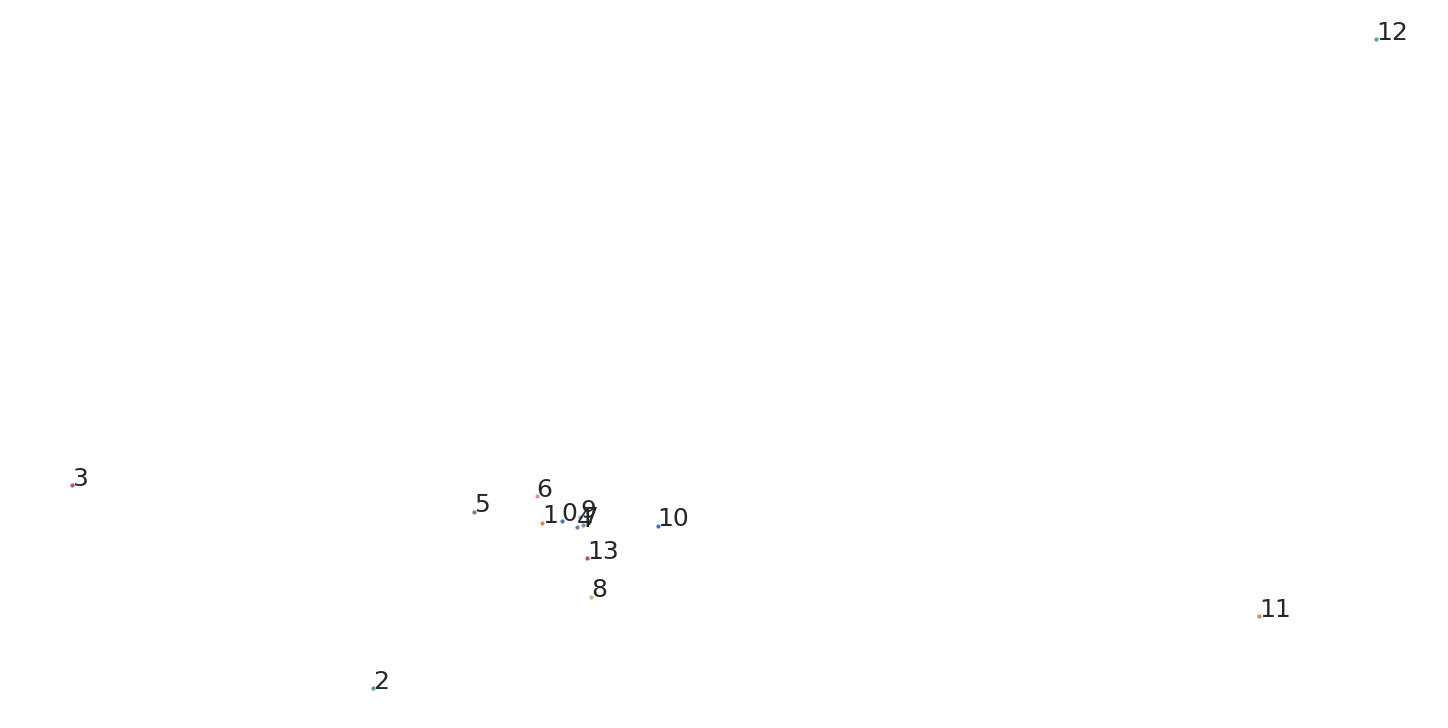

In [65]:
fontsize=25

def plot_2d(points, labels):
    fig, ax = plt.subplots(figsize=(20, 10), facecolor="white", constrained_layout=True)
    add_2d_scatter(ax, points, labels)


def add_2d_scatter(ax, points, labels):
    x, y = points.T
    for c in np.unique(labels):
        ix = np.where(labels == c)
        ax.scatter(x[ix], y[ix], label=c, s=10, alpha=1)
    
    shown = []
    for i, c in enumerate(labels):
        ax.annotate(c, (x[i], y[i]), size=fontsize)

plot_2d(S_t_sne, S_color)
# plt.legend(ncol=3, fontsize=fontsize, loc='upper left')
plt.axis('off')
# plt.savefig('results/figures/img_tSNE.pdf', dpi=300, bbox_inches='tight')
plt.show()